A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates

import src.models.complete
import src.models.individual
import src.models.unpooled
import src.models.partial
import src.models.vi

import src.models.inference
import src.models.mapping


<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [12]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

## Settings

Seed

In [13]:
RANDOM_SEED = 8924

<br>

Graphing

In [14]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [15]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [16]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')
2022-12-01 21:58:57.085


# of instances: (919, 27)
2022-12-01 21:58:57.086


# of unique codes: (919,)
2022-12-01 21:58:57.087



<br>

Extra features

In [17]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm', 'ln_radon',
       'countyindex'],
      dtype='object')
2022-12-01 21:58:57.126


# of instances: (919, 29)
2022-12-01 21:58:57.127


# of unique codes: (919,)
2022-12-01 21:58:57.128



<br>

Frequencies

In [18]:
frequencies = excerpt[['county', 'countyindex', 'floor']].groupby(by=['county', 'countyindex', 'floor'], sort=False).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-01 21:58:57.225



<br>
<br>

# Exploratory Graphs

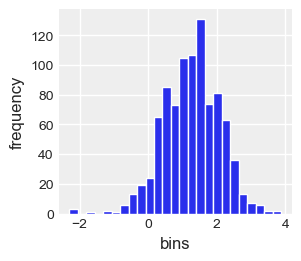

In [19]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [20]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords)


{'Level': {'Basement': 0, 'Ground': 1}, 'County': {'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 

<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [21]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The # of level group elements: (2,)
2022-12-01 21:59:00.143


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-12-01 21:59:00.216


y
2022-12-01 21:59:00.256



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

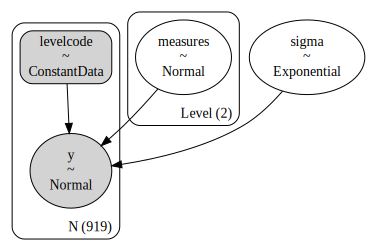

In [22]:
name = 'complete.gv'
dag.exc(model=complete, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

<span style='color: #7f7f00'><b>Test Model</b>: A different set-up, but the same model</span>

In [23]:
individual = src.models.individual.Individual(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-01 21:59:00.693



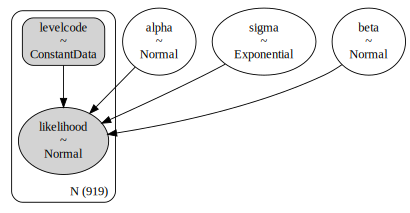

In [24]:
name = 'individual.gv'
dag.exc(model=individual, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [25]:
complete_ = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 21:59:01.921

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 21:59:01.922

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 21:59:05.412

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-01 21:59:05.414



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-12-01 21:59:36.227

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-01 21:59:42.259

Sampling: [y]

Sampling: [y]
2022-12-01 21:59:42.417



In [26]:
complete_ = src.models.mapping.Mapping(inferences=complete_, coords=coords).exc()

In [27]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

<span style='color: #7f7f00'><b>Test Model</b>: Inference</span>

In [28]:
individual_ = src.models.inference.Inference(model=individual).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 21:59:44.497

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 21:59:44.498

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 21:59:47.929

NUTS: [alpha, beta, sigma]

NUTS: [alpha, beta, sigma]
2022-12-01 21:59:47.931



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
2022-12-01 22:00:18.499

Sampling: [alpha, beta, likelihood, sigma]

Sampling: [alpha, beta, likelihood, sigma]
2022-12-01 22:00:24.500

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 22:00:24.676



In [29]:
individual_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

$\Longrightarrow$

In [30]:
individual_.posterior = individual_.posterior.assign_coords(Level=list(coords['Level'].keys()))

In [31]:
individual_ = src.models.mapping.Mapping(inferences=individual_, coords=coords).exc()

In [32]:
individual_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [33]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


    measures  level      type
0  -8.489080      0  Basement
1   8.859496      0  Basement
2 -21.954856      0  Basement
3  23.385716      0  Basement
4   4.328232      0  Basement
2022-12-01 22:00:25.809



<br>

The graph

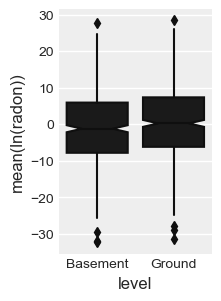

In [34]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [35]:
complete_.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 4.843 -7.589 -8.651 ... -0.2197 -1.357
Attributes:
    created_at:                 2022-12-01T21:59:42.373897
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [36]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.763183      1  Ground
1996  0.742229      1  Ground
1997  0.755005      1  Ground
1998  0.841729      1  Ground
1999  0.801915      1  Ground
2022-12-01 22:00:26.359



<br>

The distributions

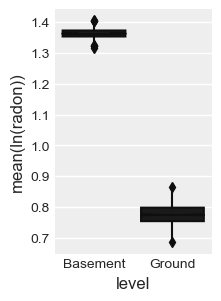

In [37]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [38]:
az.summary(complete_)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
measures[Basement],1.362,0.028,1.311,1.416,0.000,0.000,6140.0,3215.0,1.0
measures[Ground],0.776,0.063,0.658,0.891,0.001,0.001,5872.0,3218.0,1.0
sigma,0.791,0.018,0.756,0.824,0.000,0.000,5380.0,3050.0,1.0


<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

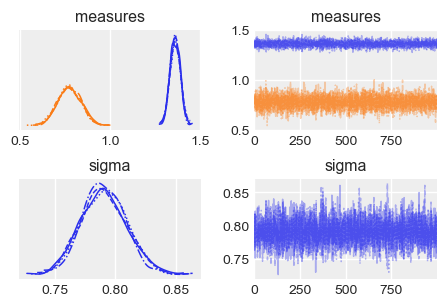

In [39]:
with complete:
    az.plot_trace(data=complete_, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013D57DF0>,
      dtype=object)

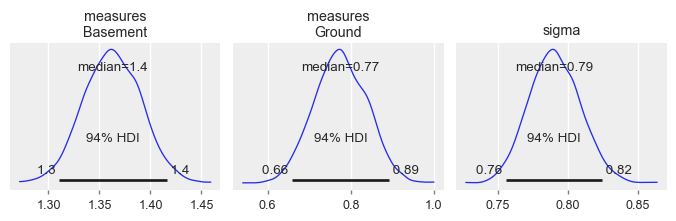

In [40]:
pm.plot_posterior(data=complete_, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>

<span style='color: #7f7f00'><b>Test Model</b></span>

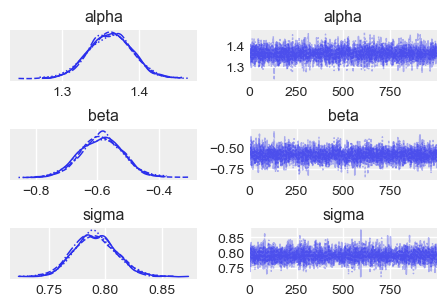

In [41]:
with individual:
    az.plot_trace(data=individual_, figsize=(4.35, 2.95))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013A12760>,
      dtype=object)

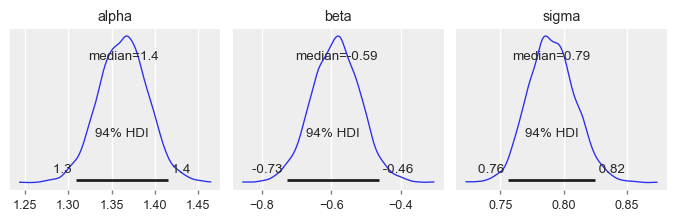

In [42]:
pm.plot_posterior(data=individual_, var_names=['alpha', 'beta', 'sigma'], 
                  figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [43]:
averages_features = complete_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.362 0.7757
    sigma      float64 0.7906

In [44]:
individual_.posterior.mean(dim=('chain', 'draw'))

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    alpha      float64 1.363
    beta       float64 -0.5866
    sigma      float64 0.7908

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [45]:
hdi_features = az.hdi(complete_)
hdi_features

<xarray.Dataset>
Dimensions:    (Level: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    measures   (Level, hdi) float64 1.311 1.416 0.6584 0.8913
    sigma      (hdi) float64 0.7556 0.8244

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

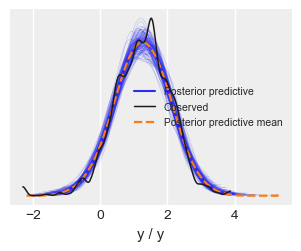

In [46]:
az.plot_ppc(data=complete_, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [47]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    complete_.posterior_predictive.y.groupby(complete_.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.12000282,  2.85631026],
       [-0.72289205,  2.26163251]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

<br>

**High Density Intervals, Averages**

Options:

* `sns.scatterplot(y=complete_.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

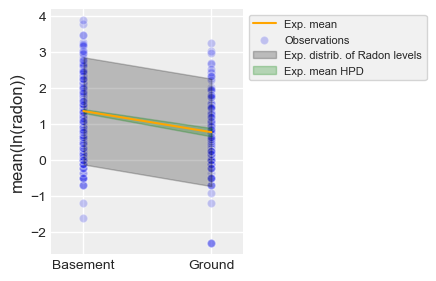

In [48]:
ax = sketch.figure(width=4.25, height=2.7)

complete_.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(complete_.posterior['LevelCode'].values)
ax.set_xticklabels(complete_.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>
<br>

**Clean-up**

In [49]:
del hdi_features, averages_features, hdi_predictive

<br>

### Inference Data

In [50]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [51]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The county & level groups: (85, 2)
2022-12-01 22:00:40.317


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-12-01 22:00:40.349


y
2022-12-01 22:00:40.371



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

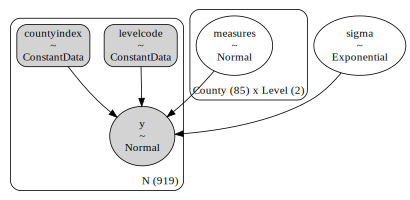

In [52]:
name = 'unpooled.gv'
dag.exc(model=unpooled, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [53]:
unpooled_ = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 22:00:41.667

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 22:00:41.668

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 22:00:45.052

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-01 22:00:45.053



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
2022-12-01 22:01:38.658

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-01 22:01:45.593

Sampling: [y]

Sampling: [y]
2022-12-01 22:01:45.770



In [54]:
unpooled_ = src.models.mapping.Mapping(inferences=unpooled_, coords=coords).exc()

In [55]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [56]:
az.summary(unpooled_)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"measures[AITKIN, Basement]",0.669,0.415,-0.124,1.413,0.006,0.005,4440.0,2921.0,1.0
"measures[AITKIN, Ground]",0.833,0.725,-0.510,2.147,0.011,0.009,4187.0,3111.0,1.0
"measures[ANOKA, Basement]",0.955,0.105,0.762,1.159,0.002,0.001,4308.0,2520.0,1.0
"measures[ANOKA, Ground]",-0.124,0.419,-0.903,0.649,0.007,0.006,3918.0,2924.0,1.0
"measures[BECKER, Basement]",1.474,0.719,0.203,2.911,0.010,0.008,4991.0,2937.0,1.0
...,...,...,...,...,...,...,...,...,...
"measures[WRIGHT, Basement]",1.679,0.205,1.305,2.077,0.003,0.002,4050.0,2645.0,1.0
"measures[WRIGHT, Ground]",0.884,0.734,-0.529,2.245,0.010,0.009,5182.0,2822.0,1.0
"measures[YELLOW MEDICINE, Basement]",1.217,0.508,0.289,2.175,0.007,0.005,4647.0,3039.0,1.0
"measures[YELLOW MEDICINE, Ground]",-0.145,10.012,-18.970,18.806,0.144,0.161,4815.0,3087.0,1.0


<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

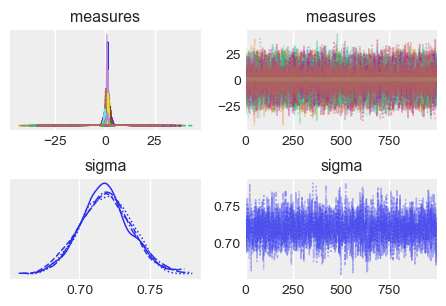

In [57]:
with unpooled:
    az.plot_trace(data=unpooled_, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

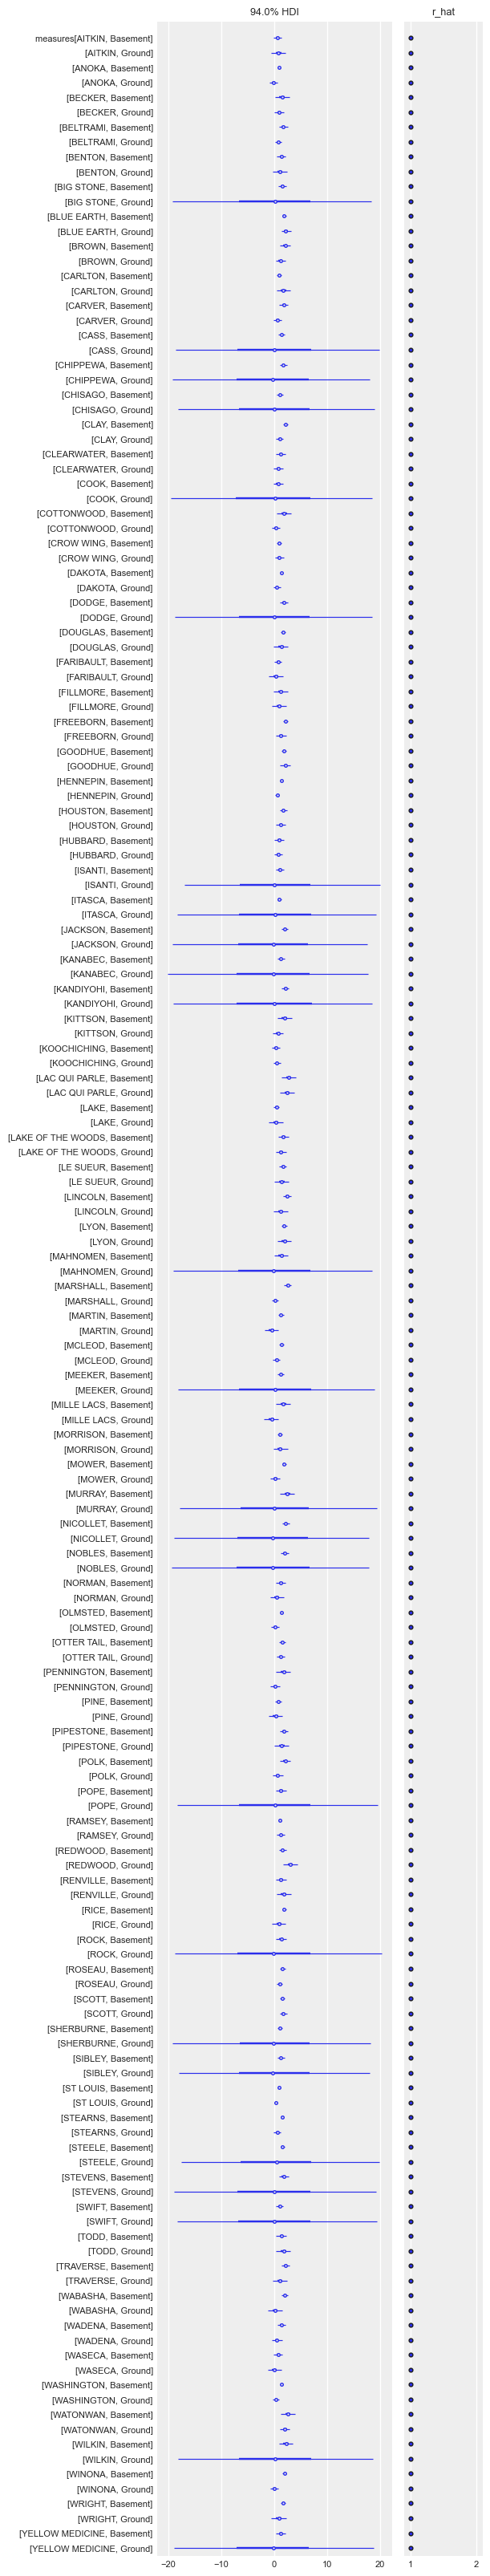

In [58]:
az.plot_forest(
    unpooled_, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [59]:
averages_features = unpooled_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (County, Level) float64 0.6692 0.8331 0.9553 ... 1.217 -0.1448
    sigma        float64 0.7186

<br>

**Posterior Check**

In [60]:
hdi_features = az.hdi(unpooled_)
hdi_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (County, Level, hdi) float64 -0.1238 1.413 ... -18.97 18.81
    sigma        (hdi) float64 0.6831 0.7516

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


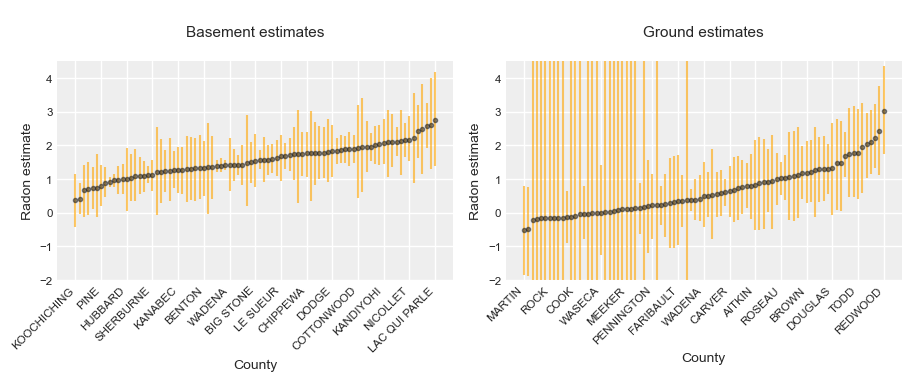

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)
    

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [62]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [63]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [64]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.919251         WATONWAN         80.0    1.0  2.0
81   36.688363           WILKIN          NaN    NaN  NaN
82    1.597912           WINONA         82.0    1.0  3.0
83    2.773975           WRIGHT         83.0    1.0  1.0
84   37.776004  YELLOW MEDICINE          NaN    NaN  NaN
2022-12-01 22:02:22.665



<br>

Some counties do not have any ground level data points

In [65]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.919251         WATONWAN         80.0    1.0  2.0
81   36.688363           WILKIN          NaN    NaN  0.0
82    1.597912           WINONA         82.0    1.0  3.0
83    2.773975           WRIGHT         83.0    1.0  1.0
84   37.776004  YELLOW MEDICINE          NaN    NaN  0.0
2022-12-01 22:02:22.678



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

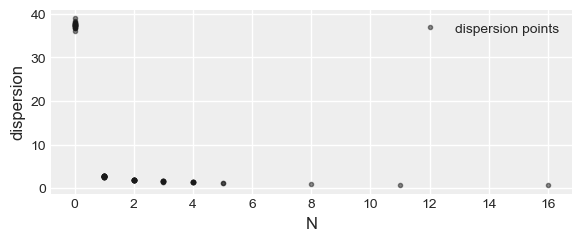

In [66]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

Upcoming

<br>
<br>

**Estimates**

Upcoming

In [67]:
averages_features['measures'].sel(County='AITKIN')

<xarray.DataArray 'measures' (Level: 2)>
array([0.66922914, 0.83308623])
Coordinates:
    County   <U17 'AITKIN'
  * Level    (Level) <U8 'Basement' 'Ground'

In [68]:
unpooled_.observed_data['y'][unpooled_.observed_data.coords['County'] == 'AITKIN']

<xarray.DataArray 'y' (N: 4)>
array([0.83290912, 1.09861229, 0.09531018, 0.83290912])
Coordinates:
  * N            (N) int32 1 2 3 0
    Level        (N) <U8 'Basement' 'Basement' 'Basement' 'Ground'
    LevelCode    (N) int32 0 0 0 1
    County       (N) <U17 'AITKIN' 'AITKIN' 'AITKIN' 'AITKIN'
    CountyIndex  (N) int32 0 0 0 0

<br>
<br>

**Clean-up**

In [69]:
del hdi_features, hdi_, averages_features, averages_

<br>
<br>

### Inference Data

In [70]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Partial

### Model

In [71]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex]: (919,)
2022-12-01 22:02:23.959


likelihood
2022-12-01 22:02:23.981



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

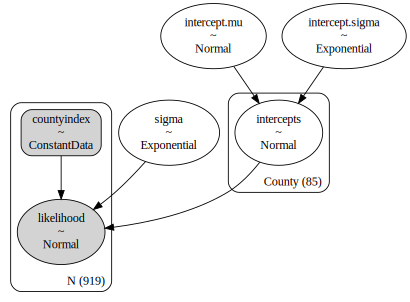

In [72]:
name = 'partial.gv'
dag.exc(model=partial, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [73]:
partial_ = src.models.inference.Inference(model=partial).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 22:02:25.799

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 22:02:25.800

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 22:02:30.336

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]
2022-12-01 22:02:30.338



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
2022-12-01 22:03:12.603

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-01 22:03:19.241

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 22:03:19.434



In [74]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

Enrich

In [75]:
partial_ = src.models.mapping.Mapping(inferences=partial_, coords=coords).exc()

In [76]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Preliminaries**

The frequencies

In [77]:
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-01 22:03:20.639



<br>

Tallies by county only.

In [78]:
T = frequencies.groupby(by=['county', 'countyindex']).agg(N=('N', sum))
T.reset_index(drop=False, inplace=True)
K = T.copy().set_index(keys='countyindex')

logger.info(T.tail())
logger.info(K.tail())


             county  countyindex   N
80         WATONWAN           80   3
81           WILKIN           81   1
82           WINONA           82  13
83           WRIGHT           83  13
84  YELLOW MEDICINE           84   2
2022-12-01 22:03:20.672


                      county   N
countyindex                     
80                  WATONWAN   3
81                    WILKIN   1
82                    WINONA  13
83                    WRIGHT  13
84           YELLOW MEDICINE   2
2022-12-01 22:03:20.676



<br>

Extra co${\ddot{o}}$rdinates



> ```python 
indices[-5:]


In [79]:
indices = partial_.posterior.coords['CountyIndex'].values

In [80]:
partial_.posterior = partial_.posterior.assign_coords({'Tally': ('County', K.iloc[indices, :]['N'].array)})

In [81]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

**Posterior Mean**

In [82]:
averages_features = partial_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:          (County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
Data variables:
    intercept.mu     float64 1.35
    intercepts       (County) float64 1.11 0.9433 1.263 ... 1.445 1.525 1.316
    intercept.sigma  float64 0.3023
    sigma            float64 0.7664

<br>

**Posterior Check**

In [83]:
hdi_features = az.hdi(partial_)
hdi_features

<xarray.Dataset>
Dimensions:          (hdi: 2, County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    intercept.mu     (hdi) float64 1.258 1.437
    intercepts       (County, hdi) float64 0.6391 1.543 0.7616 ... 0.7991 1.81
    intercept.sigma  (hdi) float64 0.2191 0.393
    sigma            (hdi) float64 0.7306 0.8011

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages,Tallies**

County tally, posterior mean, and high density interval.  `Either`

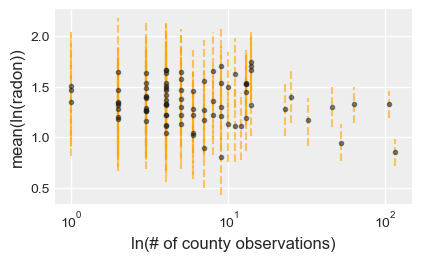

In [84]:
ax = sketch.figure(width=4.1, height=2.5)

# scatter plot
ax.plot(averages_features.coords['Tally'].values, averages_features['intercepts'].values, 'ok', markersize=3, alpha=0.5);

# high density interval lines
ax.vlines(
    hdi_features.coords['Tally'].values,
    hdi_features['intercepts'].sel(hdi='lower').values,
    hdi_features['intercepts'].sel(hdi='higher').values,
    color='orange',
    linestyles='dashed',
    alpha=0.6,
)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>

`Or`

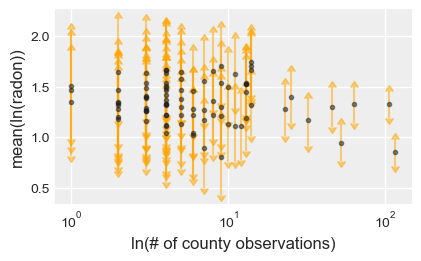

In [85]:
ax = sketch.figure(width=4.1, height=2.5)

# limits
X = np.concatenate((np.expand_dims(hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values, axis=0)))

points = averages_features['intercepts'].values
Y = np.concatenate((np.expand_dims(points - hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values - points, axis=0)))

# graph
ax.errorbar(averages_features.coords['Tally'].values, 
            averages_features['intercepts'].values, 
            Y, 
            uplims=True, lolims=True,
            ecolor='orange', 
            marker='o', markersize=3, markerfacecolor='k', markeredgecolor='k', 
            linestyle='',
            alpha=0.5)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>
<br>

**Clean-up**

In [86]:
del X, Y, hdi_features, averages_features

<br>
<br>

### Inference Data

In [87]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Varying Intercept

### Model

In [88]:
vi = src.models.vi.VI(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex] + (beta * levelcode): (919,)
2022-12-01 22:03:27.252


likelihood
2022-12-01 22:03:27.274



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(vi)`

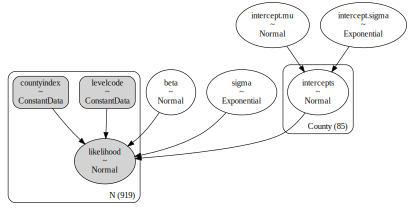

In [89]:
name = 'vi.gv'
dag.exc(model=vi, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [90]:
vi_ = src.models.inference.Inference(model=vi).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 22:03:29.527

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 22:03:29.528

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 22:03:34.934

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]
2022-12-01 22:03:34.935



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
2022-12-01 22:04:28.100

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-01 22:04:35.217

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 22:04:35.455



In [91]:
vi_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data